# 非監督式學習 - 資料分群分類

## 實作練習
### **Part 1 K-means 實作**

這次不用鳶尾花了，改用Kaggle上的資料集練習K-means的使用  
資料集連結：https://www.kaggle.com/datasets/vjchoudhary7/customer-segmentation-tutorial-in-python  

共有200筆不同顧客的消費數據，包含顧客ID、性別、年齡、年收入、消費得分等特徵  
其中年收入以千美元為單位  
消費得分介於1~100，基於顧客的消費習慣給予的數據  

我們的目標是將其中的兩類資料提取出來並將其分類

In [9]:
#1 載入資料集
import pandas as pd

# 將年收入和消費得分存在變數X中 
df_data = pd.read_csv('./dataset/Mall_Customers.csv')
X = df_data[['Annual Income (k$)', 'Spending Score (1-100)']].values

### 觀察資料集

由於是2維資料，可以先簡單的用Matplotlib將資料繪製出來觀察看看

Text(0.5, 0, 'Annual Income (k$)')

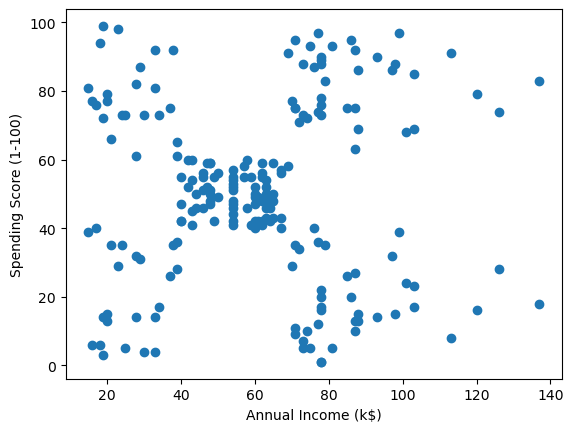

In [11]:
#2 資料視覺化
from matplotlib import pyplot as plt

# 用matplotlib繪製散布圖
plt.scatter(df_data['Annual Income (k$)'], df_data['Spending Score (1-100)'])
plt.ylabel('Spending Score (1-100)')
plt.xlabel('Annual Income (k$)')

可以用視覺大致判斷總群數應為5群，這將作為建立模型的時候k值選擇的依據

### 建立並訓練模型

根據剛才的觀察結果，將k-means模型的初始k值設為5  
並將模型訓練好之後用於預測

In [13]:
#3 建立K-means模型PI
from sklearn.cluster import KMeans

# 忽略警告
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

# 初始化，k = 5，用'k-means++'初始化中心點
kmeansModel = KMeans(n_clusters=5, init='k-means++', random_state=0)

# 擬合
kmeansModel.fit(X)

# 進行預測，得到每個樣本所屬的群體標籤
clusters_pred = kmeansModel.predict(X)

### 評估模型表現

我們可以用inertia_評估分群結果  
也可以將分群的結果繪製出來

In [15]:
#4 計算inertia評估分群品質
print(kmeansModel.inertia_)

44448.45544793371


In [17]:
#5 用cluster_centers_查看新的中心點
print(kmeansModel.cluster_centers_)

[[55.2962963  49.51851852]
 [86.53846154 82.12820513]
 [88.2        17.11428571]
 [26.30434783 20.91304348]
 [25.72727273 79.36363636]]


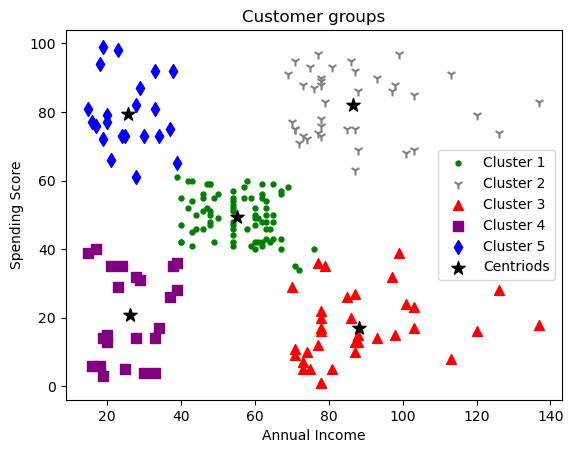

In [19]:
#6 視覺化分群的結果
# 把不同群分別繪製在散布圖上
plt.scatter(X[clusters_pred == 0, 0], X[clusters_pred == 0, 1], s=50, c='green',  marker='.', label='Cluster 1')
plt.scatter(X[clusters_pred == 1, 0], X[clusters_pred == 1, 1], s=50, c='gray',  marker='1', label='Cluster 2')
plt.scatter(X[clusters_pred == 2, 0], X[clusters_pred == 2, 1], s=50, c='red',  marker='^', label='Cluster 3')
plt.scatter(X[clusters_pred == 3, 0], X[clusters_pred == 3, 1], s=50, c='purple',  marker='s', label='Cluster 4')
plt.scatter(X[clusters_pred == 4, 0], X[clusters_pred == 4, 1], s=50, c='blue',  marker='d', label='Cluster 5')

# 繪製中心點
plt.scatter(kmeansModel.cluster_centers_[:, 0], kmeansModel.cluster_centers_[:, 1], s=100, c='black', marker='*', label='Centriods')

# 設定圖表
plt.title('Customer groups')
plt.xlabel('Annual Income')
plt.ylabel('Spending Score')
plt.legend()
plt.show()

到這裡就成功把資料分成五群了，可以明顯看出五種消費族群的差別：  
第一群：收入、消費都在平均水平    
第二群：收入高、消費高（主要目標客群）  
第三群：收入高、消費低  
第四群：收入低、消費高  
第五群：收入低、消費低  

### 確定是否為最佳k值

再來確定一下這是不是最佳結果，試著用手肘法尋找最佳k值

In [32]:
#7 迴圈計算k = 1~10的inertia
kmeans_list = [KMeans(n_clusters=k, init='k-means++', random_state=0).fit(X) for k in range(1, 10)]

# 儲存結果
inertias = [model.inertia_ for model in kmeans_list]

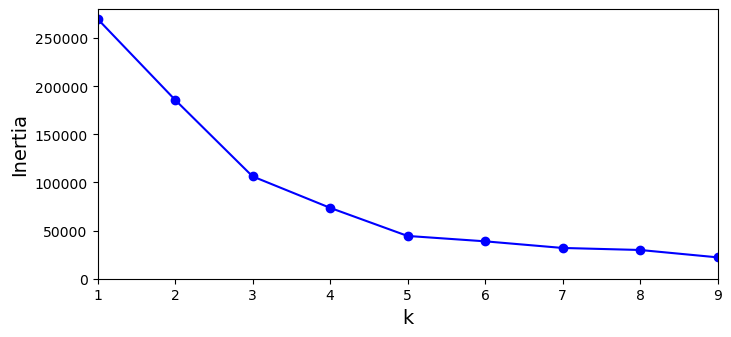

In [36]:
#8 繪製Elbow graph
plt.figure(figsize=(8, 3.5))
plt.plot(range(1, 10), inertias, "bo-")

plt.xlabel("k", fontsize=14)
plt.ylabel("Inertia", fontsize=14)
plt.axis([1, 9, 0, 280000])
plt.show()

選擇最佳k值的概念是：在圖形上變化幅度變小的那個點（一次微分的最小值）
但也不能過小，小到讓我們的分群沒有意義  

以此圖為例，我們可以得到k = 5時會有最佳的k值（坡度變化"開始"變小的位置）  
換句話說，在k = 5時，K-means會有最好的分群效果

此外，從圖表可以發現，k的值越大，inertia會越小，最後趨近於零  
所以不能盲目的選擇inertia最小的k值（否則k = n，跟沒分一樣）  
最佳的k值應該要能夠在模型的複雜性和解釋性之間取得平衡，使K-means分群結果更有效

### **Part 2 PCA, t-SNE降維實作**

用手寫數字圖像資料集練習  
資料集連結：https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_digits.html  

共有1979張手寫數字圖像，每張的圖像解析度皆為8x8巷素，包含數字0~9  

我們的目標是將高維度的圖像降維到二維平面，觀察並比較兩種方法在視覺化手寫數字的表現  

In [43]:
#1 載入資料集
from sklearn.datasets import load_digits

digits = load_digits()

# 提取X, y資料
X = digits.data
y = digits.target

print('X shape: ', X.shape)

X shape:  (1797, 64)


### 視覺化資料

這邊還是先將資料視覺化看看，保持一個好習慣

<Figure size 640x480 with 0 Axes>

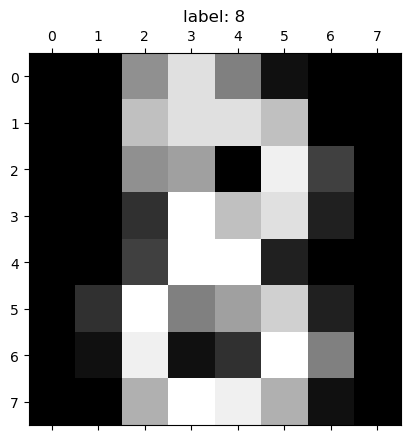

In [46]:
#2 視覺化資料
index = 8
plt.gray()
plt.matshow(X[index].reshape(8,8))
plt.title(f'label: {y[index]}')
plt.show()

### 分割資料集

確定資料沒問題了之後，把資料集分割成訓練60%、驗證20%、測試20%  
其中：  
訓練集用於訓練模型  
驗證集用於測試模型  
測試集用於最終成果評估

In [52]:
#3 分割資料
from sklearn.model_selection import train_test_split

# 先分出測試集的20%
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 再分出驗證集的20%，剩下的就是訓練集
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42)

print('Train set shape:', X_train.shape)
print('Validation set shape:', X_val.shape)
print('Test set shape:', X_test.shape)

Train set shape: (1077, 64)
Validation set shape: (360, 64)
Test set shape: (360, 64)


### PCA降維

先從PCA降維開始

In [83]:
#4 對數據進行PCA降維
from sklearn.decomposition import PCA

# 初始化PCA
pca = PCA(n_components=2)

# 對訓練集進行降維
train_pca = pca.fit_transform(X_train)

# 觀察訓練結果
print('PCA Variance ratio: ', pca.explained_variance_ratio_)
print('PCA Variance: ', pca.explained_variance_)

# 將模型套用到驗證集和測試集上
val_pca = pca.transform(X_val)
test_pca = pca.transform(X_test)

PCA Variance ratio:  [0.14737583 0.13763323]
PCA Variance:  [177.09555715 165.38826488]


### 觀察降維結果

降維後，同一個種類的資料間的距離應該要很近，我們可以將其繪製成散布圖來觀察結果（因為剛剛降到2維）

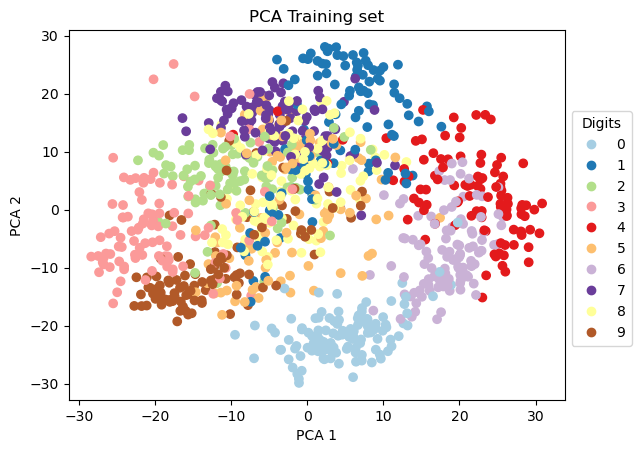

In [59]:
#5 視覺化PCA降維後的訓練集
# 繪製散布圖
scatter = plt.scatter(train_pca[:, 0], train_pca[:, 1], c=y_train, cmap=plt.cm.Paired)
plt.legend(*scatter.legend_elements(), title="Digits", bbox_to_anchor=(1, 0.8))
plt.title("PCA Training set")
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.show()

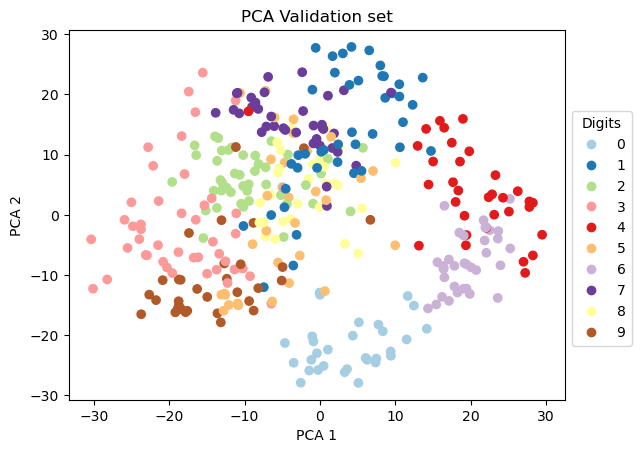

In [67]:
#6 視覺化PCA降維後的驗證集
# 繪製散布圖
scatter = plt.scatter(val_pca[:, 0], val_pca[:, 1], c=y_val, cmap=plt.cm.Paired)
plt.legend(*scatter.legend_elements(), title="Digits", bbox_to_anchor=(1, 0.8))
plt.title("PCA Validation set")
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.show()

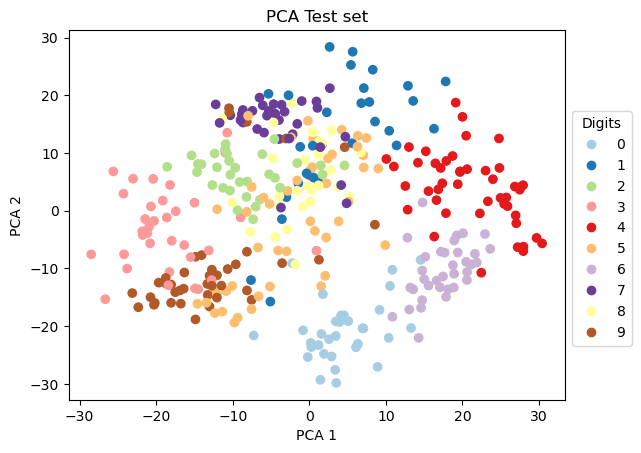

In [69]:
#7 視覺化PCA降維後的測試集
# 繪製散布圖
scatter = plt.scatter(test_pca[:, 0], test_pca[:, 1], c=y_test, cmap=plt.cm.Paired)
plt.legend(*scatter.legend_elements(), title="Digits", bbox_to_anchor=(1, 0.8))
plt.title("PCA Test set")
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.show()

可以發現三張圖的結果相同：準度不高、精度更慘  
同種數字的資料不會相距太遠（還是在一定範圍內），但整體的分布範圍太大了，所以有很多不同種特徵重疊、混合的情況  

表示PCA在處理這項資料（非線性資料）的效果並不好，這就是PCA最大的劣勢

### t-SNE降維

接著換t-SNE降維

In [77]:
#8 對數據進行t-SNE降維
from sklearn.manifold import TSNE

# 降維（只能用單一資料）
tsne_train = TSNE(n_components=2, random_state=42).fit_transform(X_train)

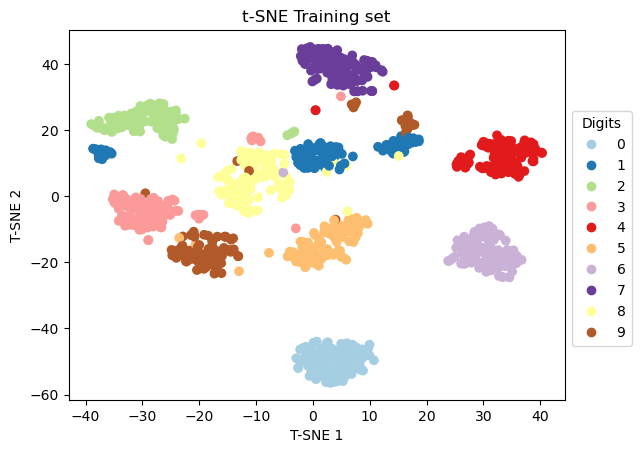

In [78]:
#9 視覺化t-SNE降維結果
# 繪製散布圖
scatter = plt.scatter(tsne_train[:, 0], tsne_train[:, 1], c=y_train, cmap=plt.cm.Paired)
plt.legend(*scatter.legend_elements(), title="Digits", bbox_to_anchor=(1, 0.8))
plt.title("t-SNE Training set")
plt.xlabel('T-SNE 1')
plt.ylabel('T-SNE 2')
plt.show()

結果可以發現，這次不同種類的數字分得比較開、整體乾淨了許多  

結論：與PCA相比，t-SNE可以更有效的捕捉數據中的非線性結構，使不同類別的數據點更分離  
實務上，可以把t-SNE降維的結果直接用於非監督式K-means分群，找到十個不同的中心點；或用監督式學習進行分類器訓練和預測  
但是要記得，由於演算法的限制，t-SNE演算法沒有transform可以用，只適用於一次性的數據降維、視覺化，不適用於新資料（因為每次運行都要重新計算數據點之間的相似度和嵌入，若有新數據則無法保證新數據和原始數據的一致性）